In [ ]:
# Something about data.
import os

index_dir = os.path.join("index")
index_test_path = os.path.join(index_dir, "gene_index.01_test.csv")
index_training_validation_path = os.path.join(index_dir, "gene_index.01_train_validation.csv")
gene_dir = os.path.join("data", "gene_dir")



In [1]:
# Import Lib

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import tensorflow as tf
import keras.utils
from keras.layers import Embedding, Dense, Flatten, Dropout, SpatialDropout1D, TimeDistributed, LSTM, GRU, Bidirectional
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from keras import Input, Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import os

baseline_dir = os.path.join("data", "baseline")
model_dir = os.path.join(baseline_dir, "model")
data_dir = os.path.join(baseline_dir, "kmer")
num_classes = 8

In [7]:
import numpy as np
characters = ["A", "C", "G", "T"]

kmer_dict = {}
count = 0
embedding_vectors = []
for a in characters:
  for b in characters:
    for c in characters:
      v = [0 for i in range(64)]
      kmer_dict[f"{a}{b}{c}"] = count
      v[count] = 1
      embedding_vectors.append(v)
      count += 1

embedding_vectors = np.array(embedding_vectors)
print(embedding_vectors.shape)
print(kmer_dict)
embedding_matrix = embedding_vectors

Label_Dictionary = {
    '[CLS]': -100, #_create_one_hot_encoding(0, 10),
    '[SEP]': -100,
    # '[PAD]': 2, #_create_one_hot_encoding(9, 10)
    'III': -100,   # Created III instead of iii for PAD special token. 
                # This is for enabling reading contigs if token is predicted as padding. 
                # #_create_one_hot_encoding(9, 10)
    'iii': 0,   #_create_one_hot_encoding(1, 10),
    'iiE': 1,   #_create_one_hot_encoding(2, 10),
    'iEi': 2,   #_create_one_hot_encoding(3, 10),
    'Eii': 3,   #_create_one_hot_encoding(4, 10),
    'iEE': 4,   #_create_one_hot_encoding(5, 10),
    'EEi': 5,   #_create_one_hot_encoding(6, 10),
    'EiE': 6,   #_create_one_hot_encoding(7, 10),
    'EEE': 7,  #_create_one_hot_encoding(8, 10),
}

label_dict = Label_Dictionary

Index_Dictionary = {
    #0: "[CLS]",
    #1: "[SEP]",
    #2: "III",       # Use `III` as padding symbol.
    0: "iii",
    1: "iiE",
    2: "iEi",
    3: "Eii",
    4: "iEE",
    5: "EEi",
    6: "EiE",
    7: "EEE",
    -100: "[CLS]/[SEP]/[III]"
}

import os
import pandas as pd
import numpy as np
from tqdm import tqdm

training_data_path = os.path.join(data_dir, "gene_index.01_train_validation_ss_all_pos_train.csv")
validation_data_path = os.path.join(data_dir, "gene_index.01_train_validation_ss_all_pos_validation.csv")
test_data_path = os.path.join(data_dir, "gene_index.01_test_ss_all_pos.csv")

def preprocessing(data_path):
  if os.path.exists(data_path):
    print(f"data exists at {data_path}")
  else:
    raise FileNotFoundError(f"data not found ata {data_path}")
  encoded_sequences = []
  encoded_labels = []
  df = pd.read_csv(data_path)
  for i, r in tqdm(df.iterrows(), total=df.shape[0], desc="Preprocessing"):
    sequence = r["sequence"]
    label = r["label"]

    encoded_sequence = [kmer_dict[a] for a in sequence.split(' ')]
    encoded_label = [label_dict[a] for a in label.split(' ')]

    if len(encoded_sequence) != 512 or len(encoded_label) != 512:
      raise ValueError(f"input size not correct. expected 512 and 512, found {len(encoded_sequence)} {len(encoded_label)}")

    encoded_sequences.append(
        encoded_sequence
    )
    encoded_labels.append(
        encoded_label
    )
  return encoded_sequences, encoded_labels


X_train, Y_train = preprocessing(training_data_path)
X_train = np.array(X_train)
Y_train = np.array([tf.keras.utils.to_categorical(y, num_classes=num_classes) for y in Y_train])
X_val, Y_val = preprocessing(validation_data_path)
X_val = np.array(X_val)
Y_val = np.array([tf.keras.utils.to_categorical(y, num_classes=num_classes) for y in Y_val])
X_test, Y_test = preprocessing(test_data_path)
X_test = np.array(X_test)
Y_test = np.array([tf.keras.utils.to_categorical(y, num_classes=num_classes) for y in Y_test])

print(f"Training data {np.array(X_train).shape}, {np.array(Y_train).shape}")
print(f"Validation data {np.array(X_val).shape}, {np.array(Y_val).shape}")
print(f"Test data {np.array(X_test).shape}, {np.array(Y_test).shape}")

(64, 64)
{'AAA': 0, 'AAC': 1, 'AAG': 2, 'AAT': 3, 'ACA': 4, 'ACC': 5, 'ACG': 6, 'ACT': 7, 'AGA': 8, 'AGC': 9, 'AGG': 10, 'AGT': 11, 'ATA': 12, 'ATC': 13, 'ATG': 14, 'ATT': 15, 'CAA': 16, 'CAC': 17, 'CAG': 18, 'CAT': 19, 'CCA': 20, 'CCC': 21, 'CCG': 22, 'CCT': 23, 'CGA': 24, 'CGC': 25, 'CGG': 26, 'CGT': 27, 'CTA': 28, 'CTC': 29, 'CTG': 30, 'CTT': 31, 'GAA': 32, 'GAC': 33, 'GAG': 34, 'GAT': 35, 'GCA': 36, 'GCC': 37, 'GCG': 38, 'GCT': 39, 'GGA': 40, 'GGC': 41, 'GGG': 42, 'GGT': 43, 'GTA': 44, 'GTC': 45, 'GTG': 46, 'GTT': 47, 'TAA': 48, 'TAC': 49, 'TAG': 50, 'TAT': 51, 'TCA': 52, 'TCC': 53, 'TCG': 54, 'TCT': 55, 'TGA': 56, 'TGC': 57, 'TGG': 58, 'TGT': 59, 'TTA': 60, 'TTC': 61, 'TTG': 62, 'TTT': 63}
data exists at data\baseline\kmer\gene_index.01_train_validation_ss_all_pos_train.csv


Preprocessing: 100%|██████████| 71058/71058 [00:14<00:00, 4878.63it/s]


data exists at data\baseline\kmer\gene_index.01_train_validation_ss_all_pos_validation.csv


Preprocessing: 100%|██████████| 17765/17765 [00:03<00:00, 4801.34it/s]


data exists at data\baseline\kmer\gene_index.01_test_ss_all_pos.csv


Preprocessing: 100%|██████████| 6977/6977 [00:01<00:00, 5044.95it/s]


Training data (71058, 512), (71058, 512, 8)
Validation data (17765, 512), (17765, 512, 8)
Test data (6977, 512), (6977, 512, 8)


In [6]:
import os
import tensorflow as tf

model_dir = os.path.join("run", "baseline", "kmer", "model")
model_bilstm_path = os.path.join(model_dir, "model_bilstm.h5")
model_bigru_path = os.path.join(model_dir, "model_bigru.h5")
data_dir = os.path.join("workspace", "seqlab-latest")
test_data_path = os.path.join(data_dir, "gene_index.01_test_ss_all_pos.csv")

for p in [model_bilstm_path, model_bigru_path, test_data_path]:
    print(f"Path {p} {'found' if os.path.exists(p) else 'not found'}")


bilstm_model = tf.keras.models.load_model(model_bilstm_path)
bigru_model = tf.keras.models.load_model(model_bigru_path)

from run_baseline_kmer import preprocessing

X_test, Y_test = preprocessing(test_data_path)
print(f"{X_test.shape}, {Y_test.shape}")



Path run\baseline\kmer\model\model_bilstm.h5 found
Path run\baseline\kmer\model\model_bigru.h5 found
Path workspace\seqlab-latest\gene_index.01_test_ss_all_pos.csv found


Preprocessing: 100%|██████████| 6961/6961 [00:01<00:00, 3928.69it/s]


(6961, 510), (6961, 510, 8)


In [7]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
# prediction.
num_classes = 8
import numpy as np
import pandas as pd
import os
from utils.seqlab import Index_Dictionary, Label_Dictionary
from utils.metrics import Metrics
from sklearn.metrics import classification_report

log_prediction_dir = os.path.join("run", "baseline", "kmer", "log", "prediction-latest")
os.makedirs(log_prediction_dir, exist_ok=True)

for mset in [("bilstm", bilstm_model), ("bigru", bigru_model)]:
    model_name = mset[0]
    model = mset[1]

    # predict!
    y_pred = model.predict(X_test)
    print(y_pred.shape, Y_test.shape)

    # get label index
    y_pred_ids = np.argmax(y_pred, axis=-1)
    y_test_ids = np.argmax(Y_test, axis=-1)
    print(y_pred_ids.shape, y_test_ids.shape)

    token_f1_scores = {}
    token_precision = {}
    token_recall = {}
    for k in [k for k in Label_Dictionary.keys() if Label_Dictionary[k] >= 0]:
        token_f1_scores[k] = []
        token_precision[k] = []
        token_recall[k] = []

    prediction_steps = []
    y_preds = []
    y_targets = []
    prediction_step = 0
    for y_pred, y_test in zip(y_pred_ids, y_test_ids):
        y_pred_str = [str(a) for a in y_pred]
        y_pred_str = " ".join(y_pred_str)
        y_preds.append(y_pred_str)

        y_test_str = [str(a) for a in y_test]
        y_test_str = " ".join(y_test_str)
        y_targets.append(y_test_str)
        metrics = Metrics(y_pred, y_test)
        metrics.calculate()
        for label_index in range(num_classes):
            j = Index_Dictionary[label_index]
            token_f1_scores[j].append(metrics.f1_score(label_index))
            token_precision[j].append(metrics.precision(label_index))
            token_recall[j].append(metrics.recall(label_index))
        prediction_steps.append(prediction_step)
        prediction_step += 1

    df_data = {}
    df_data["step"] = prediction_steps
    df_data["prediction"] = y_preds
    df_data["target"] = y_targets
    for k in token_f1_scores.keys():
        df_data[f"f1_score-{k}"] = token_f1_scores[k]
    for k in token_precision.keys():
        df_data[f"precision-{k}"] = token_precision[k]
    for k in token_recall.keys():
        df_data[f"recall-{k}"] = token_recall[k]
    
    log_df = pd.DataFrame(data=df_data)
    log_df.to_csv(os.path.join(log_prediction_dir, f"log.{model_name}.csv"), index=False)

    y_pred_ids_flatten = y_pred_ids.flatten()
    y_test_ids_flatten = y_test_ids.flatten()

    label_indices = [i for i in range(num_classes)]
    print(y_pred_ids_flatten.shape, y_test_ids_flatten.shape)
    print(y_pred_ids_flatten, all([a in label_indices for a in y_pred_ids_flatten]))
    print(y_test_ids_flatten, all([a in label_indices for a in y_test_ids_flatten]))
    print(num_classes)
    print(classification_report(
        y_test_ids_flatten, 
        y_pred_ids_flatten, 
        labels=[i for i in range(num_classes)], 
        target_names=[Index_Dictionary.get(i) for i in range(num_classes)], 
        zero_division=0))

218/218 [==============================] - 110s 504ms/step
(6961, 510, 8) (6961, 510, 8)
(6961, 510) (6961, 510)
(3550110,) (3550110,)
[0 0 0 ... 7 7 7] True
[7 7 7 ... 7 7 7] True
8
              precision    recall  f1-score   support

         iii       0.83      0.88      0.86   2680835
         iiE       0.64      0.34      0.44      5835
         iEi       0.00      0.00      0.00         0
         Eii       0.49      0.40      0.44      5854
         iEE       0.43      0.26      0.32      5834
         EEi       0.51      0.38      0.44      5853
         EiE       0.00      0.00      0.00         0
         EEE       0.54      0.44      0.49    845899

   micro avg       0.77      0.77      0.77   3550110
   macro avg       0.43      0.34      0.37   3550110
weighted avg       0.76      0.77      0.76   3550110

218/218 [==============================] - 119s 546ms/step
(6961, 510, 8) (6961, 510, 8)
(6961, 510) (6961, 510)
(3550110,) (3550110,)
[0 0 0 ... 7 7 7] True
[7 7 7 .

data size bilstm 6961, bigru 6961


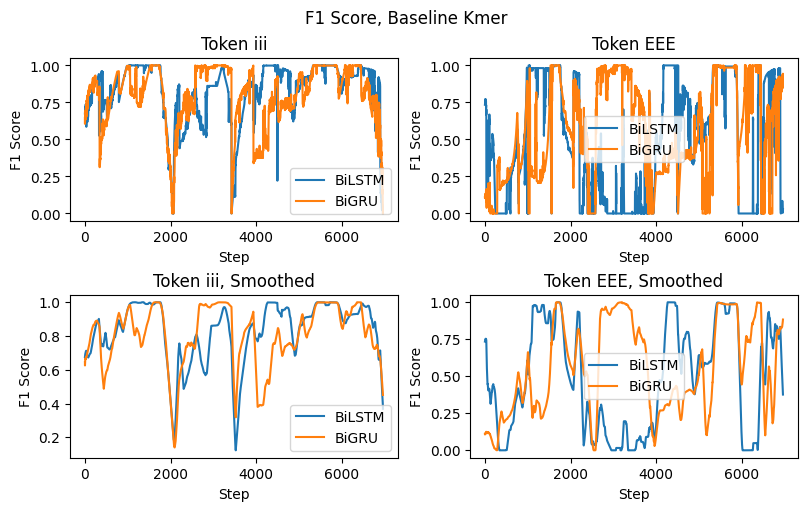

In [5]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils.viz import running_average_smoothing

log_dir = os.path.join("run", "baseline", "kmer", "log", "prediction")
bilstm_log = pd.read_csv(os.path.join(log_dir, "log.bilstm.csv"))
bigru_log = pd.read_csv(os.path.join(log_dir, "log.bigru.csv"))

data_size = bilstm_log.shape[0]
print(f"data size bilstm {bilstm_log.shape[0]}, bigru {bigru_log.shape[0]}")

figs, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(8, 5))
xs = [i for i in range(data_size)]

# iii
axes[0][0].plot(
    xs,
    bilstm_log["f1_score-iii"],
    label="BiLSTM"
)
axes[0][0].plot(
    xs,
    bigru_log["f1_score-iii"],
    label="BiGRU"
)
axes[0][0].set(xlabel="Step", ylabel="F1 Score", title="Token iii")
axes[0][0].legend()

# EEE
axes[0][1].plot(
    xs,
    bilstm_log["f1_score-EEE"],
    label="BiLSTM"
)
axes[0][1].plot(
    xs,
    bigru_log["f1_score-EEE"],
    label="BiGRU"
)
axes[0][1].set(xlabel="Step", ylabel="F1 Score", title="Token EEE")
axes[0][1].legend()

# iii
axes[1][0].plot(
    xs,
    running_average_smoothing(bilstm_log["f1_score-iii"], 100),
    label="BiLSTM"
)
axes[1][0].plot(
    xs,
    running_average_smoothing(bigru_log["f1_score-iii"], 100),
    label="BiGRU"
)
axes[1][0].set(xlabel="Step", ylabel="F1 Score", title="Token iii, Smoothed")
axes[1][0].legend()

# EEE
axes[1][1].plot(
    xs,
    running_average_smoothing(bilstm_log["f1_score-EEE"], 100),
    label="BiLSTM"
)
axes[1][1].plot(
    xs,
    running_average_smoothing(bigru_log["f1_score-EEE"], 100),
    label="BiGRU"
)
axes[1][1].set(xlabel="Step", ylabel="F1 Score", title="Token EEE, Smoothed")
axes[1][1].legend()

plt.suptitle("F1 Score, Baseline Kmer")
plt.show()

data size bilstm 6961, bigru 6961


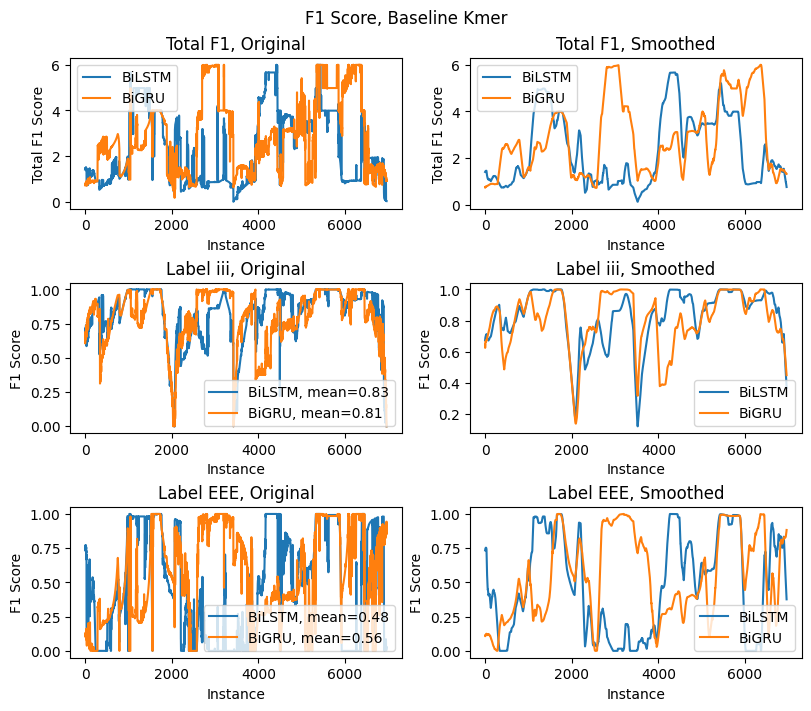

In [18]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from utils.viz import running_average_smoothing

log_dir = os.path.join("run", "baseline", "kmer", "log", "prediction")
bilstm_log_path = os.path.join(log_dir, "log.bilstm.csv")
bilstm_log = pd.read_csv(bilstm_log_path)
bilstm_log["total_f1_score"] = bilstm_log["f1_score-iii"] + bilstm_log["f1_score-iiE"] + bilstm_log["f1_score-iEE"] + bilstm_log["f1_score-Eii"] + bilstm_log["f1_score-EEi"] + bilstm_log["f1_score-EEE"]
bilstm_log.to_csv(bilstm_log_path, index=False)

bigru_log_path = os.path.join(log_dir, "log.bigru.csv")
bigru_log = pd.read_csv(bigru_log_path)
bigru_log["total_f1_score"] = bigru_log["f1_score-iii"] + bigru_log["f1_score-iiE"] + bigru_log["f1_score-iEE"] + bigru_log["f1_score-Eii"] + bigru_log["f1_score-EEi"] + bigru_log["f1_score-EEE"]
bigru_log.to_csv(bigru_log_path, index=False)

data_size = bilstm_log.shape[0]
print(f"data size bilstm {bilstm_log.shape[0]}, bigru {bigru_log.shape[0]}")

figs, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(8, 7))
xs = [i for i in range(data_size)]

# original
axes[0][0].plot(
    xs,
    bilstm_log["total_f1_score"],
    label="BiLSTM"
)
axes[0][0].plot(
    xs,
    bigru_log["total_f1_score"],
    label="BiGRU"
)
axes[0][0].set(xlabel="Instance", ylabel="Total F1 Score", title="Total F1, Original")
axes[0][0].legend()

# smoothed
axes[0][1].plot(
    xs,
    running_average_smoothing(bilstm_log["total_f1_score"], 100),
    label="BiLSTM"
)
axes[0][1].plot(
    xs,
    running_average_smoothing(bigru_log["total_f1_score"], 100),
    label="BiGRU"
)
axes[0][1].set(xlabel="Instance", ylabel="Total F1 Score", title="Total F1, Smoothed")
axes[0][1].legend()

# original iii
axes[1][0].plot(
    xs,
    bilstm_log["f1_score-iii"],
    label=f"BiLSTM, mean={round(np.average(bilstm_log['f1_score-iii']), 2)}"
)
axes[1][0].plot(
    xs,
    bigru_log["f1_score-iii"],
    label=f"BiGRU, mean={round(np.average(bigru_log['f1_score-iii']), 2)}"
)
axes[1][0].set(xlabel="Instance", ylabel="F1 Score", title="Label iii, Original")
axes[1][0].legend()

# smoothed
axes[1][1].plot(
    xs,
    running_average_smoothing(bilstm_log["f1_score-iii"], 100),
    label="BiLSTM"
)
axes[1][1].plot(
    xs,
    running_average_smoothing(bigru_log["f1_score-iii"], 100),
    label="BiGRU"
)
axes[1][1].set(xlabel="Instance", ylabel="F1 Score", title="Label iii, Smoothed")
axes[1][1].legend()

# original EEE
axes[2][0].plot(
    xs,
    bilstm_log["f1_score-EEE"],
    label=f"BiLSTM, mean={round(np.average(bilstm_log['f1_score-EEE']), 2)}"
)
axes[2][0].plot(
    xs,
    bigru_log["f1_score-EEE"],
    label=f"BiGRU, mean={round(np.average(bigru_log['f1_score-EEE']), 2)}"
)
axes[2][0].set(xlabel="Instance", ylabel="F1 Score", title="Label EEE, Original")
axes[2][0].legend()

# smoothed
axes[2][1].plot(
    xs,
    running_average_smoothing(bilstm_log["f1_score-EEE"], 100),
    label="BiLSTM"
)
axes[2][1].plot(
    xs,
    running_average_smoothing(bigru_log["f1_score-EEE"], 100),
    label="BiGRU"
)
axes[2][1].set(xlabel="Instance", ylabel="F1 Score", title="Label EEE, Smoothed")
axes[2][1].legend()


plt.suptitle("F1 Score, Baseline Kmer")
plt.show()

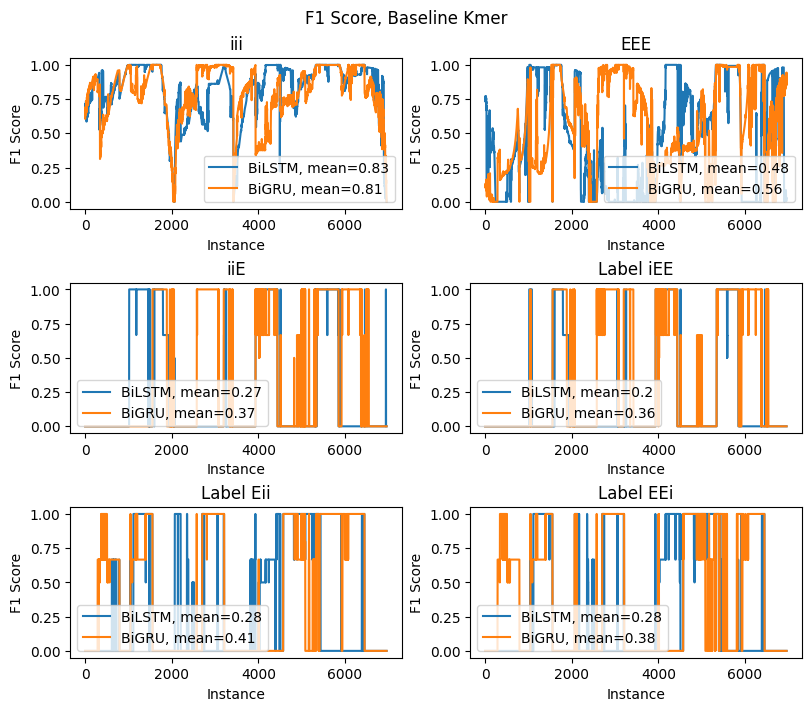

In [21]:
# Plot for each token label.

figs, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(8, 7))
xs = [i for i in range(data_size)]

# iii
axes[0][0].plot(
    xs,
    bilstm_log["f1_score-iii"],
    label=f"BiLSTM, mean={round(np.average(bilstm_log['f1_score-iii']), 2)}"
)
axes[0][0].plot(
    xs,
    bigru_log["f1_score-iii"],
    label=f"BiGRU, mean={round(np.average(bigru_log['f1_score-iii']), 2)}"
)
axes[0][0].set(xlabel="Instance", ylabel="F1 Score", title="iii")
axes[0][0].legend()

# EEE
axes[0][1].plot(
    xs,
    bilstm_log["f1_score-EEE"],
    label=f"BiLSTM, mean={round(np.average(bilstm_log['f1_score-EEE']), 2)}"
)
axes[0][1].plot(
    xs,
    bigru_log["f1_score-EEE"],
    label=f"BiGRU, mean={round(np.average(bigru_log['f1_score-EEE']), 2)}"
)
axes[0][1].set(xlabel="Instance", ylabel="F1 Score", title="EEE")
axes[0][1].legend()

# iiE
axes[1][0].plot(
    xs,
    bilstm_log["f1_score-iiE"],
    label=f"BiLSTM, mean={round(np.average(bilstm_log['f1_score-iiE']), 2)}"
)
axes[1][0].plot(
    xs,
    bigru_log["f1_score-iiE"],
    label=f"BiGRU, mean={round(np.average(bigru_log['f1_score-iiE']), 2)}"
)
axes[1][0].set(xlabel="Instance", ylabel="F1 Score", title="iiE")
axes[1][0].legend()

# iEE
axes[1][1].plot(
    xs,
    bilstm_log["f1_score-iEE"],
    label=f"BiLSTM, mean={round(np.average(bilstm_log['f1_score-iEE']), 2)}"
)
axes[1][1].plot(
    xs,
    bigru_log["f1_score-iEE"],
    label=f"BiGRU, mean={round(np.average(bigru_log['f1_score-iEE']), 2)}"
)
axes[1][1].set(xlabel="Instance", ylabel="F1 Score", title="Label iEE")
axes[1][1].legend()

# Eii
axes[2][0].plot(
    xs,
    bilstm_log["f1_score-Eii"],
    label=f"BiLSTM, mean={round(np.average(bilstm_log['f1_score-Eii']), 2)}"
)
axes[2][0].plot(
    xs,
    bigru_log["f1_score-Eii"],
    label=f"BiGRU, mean={round(np.average(bigru_log['f1_score-Eii']), 2)}"
)
axes[2][0].set(xlabel="Instance", ylabel="F1 Score", title="Label Eii")
axes[2][0].legend()

# EEi
axes[2][1].plot(
    xs,
    bilstm_log["f1_score-EEi"],
    label=f"BiLSTM, mean={round(np.average(bilstm_log['f1_score-EEi']), 2)}"
)
axes[2][1].plot(
    xs,
    bigru_log["f1_score-EEi"],
    label=f"BiGRU, mean={round(np.average(bigru_log['f1_score-EEi']), 2)}"
)
axes[2][1].set(xlabel="Instance", ylabel="F1 Score", title="Label EEi")
axes[2][1].legend()


plt.suptitle("F1 Score, Baseline Kmer")
plt.show()

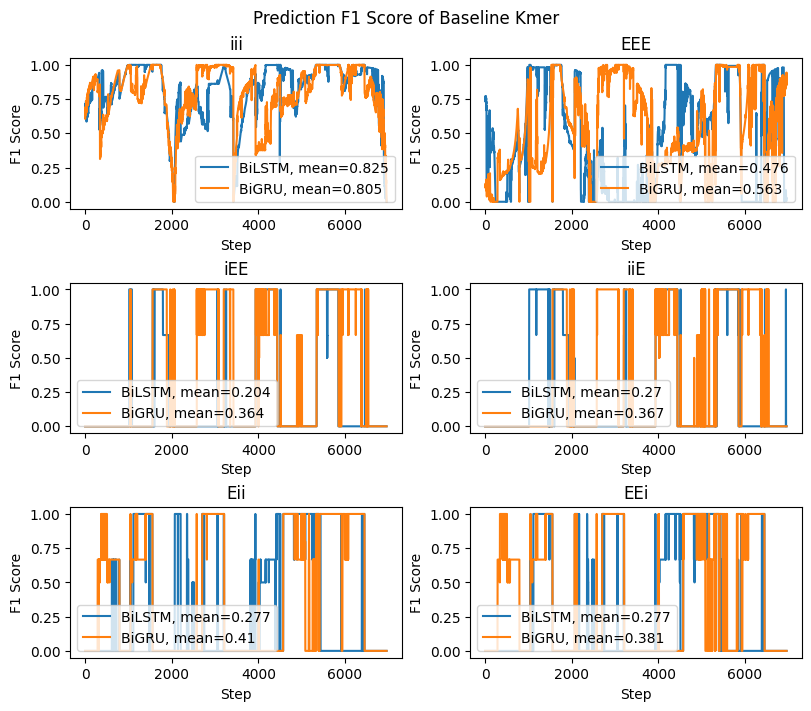

In [4]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from utils.viz import running_average_smoothing

log_dir = os.path.join("run", "baseline", "kmer", "log", "prediction")
bilstm_log_path = os.path.join(log_dir, "log.bilstm.csv")
bilstm_log = pd.read_csv(bilstm_log_path)
bilstm_log["total_f1_score"] = bilstm_log["f1_score-iii"] + bilstm_log["f1_score-iiE"] + bilstm_log["f1_score-iEE"] + bilstm_log["f1_score-Eii"] + bilstm_log["f1_score-EEi"] + bilstm_log["f1_score-EEE"]
bilstm_log.to_csv(bilstm_log_path, index=False)

bigru_log_path = os.path.join(log_dir, "log.bigru.csv")
bigru_log = pd.read_csv(bigru_log_path)
bigru_log["total_f1_score"] = bigru_log["f1_score-iii"] + bigru_log["f1_score-iiE"] + bigru_log["f1_score-iEE"] + bigru_log["f1_score-Eii"] + bigru_log["f1_score-EEi"] + bigru_log["f1_score-EEE"]
bigru_log.to_csv(bigru_log_path, index=False)

labels = ["iii", "EEE", "iEE", "iiE", "Eii", "EEi"]
figs, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(8, 7))
xs = [i for i in range(bilstm_log.shape[0])]
cur_label_index = 0

for i in [0, 1, 2]:
    for j in [0, 1]:
        cur_label = labels[cur_label_index]
        axes[i][j].plot(
            xs,
            bilstm_log[f"f1_score-{cur_label}"],
            label=f"BiLSTM, mean={round(np.average(bilstm_log[f'f1_score-{cur_label}']), 3)}"
        )
        axes[i][j].plot(
            xs,
            bigru_log[f"f1_score-{cur_label}"],
            label=f"BiGRU, mean={round(np.average(bigru_log[f'f1_score-{cur_label}']), 3)}"
        )
        axes[i][j].set(xlabel="Step", ylabel="F1 Score", title=f"{cur_label}")
        axes[i][j].legend()
        cur_label_index += 1

plt.suptitle("Prediction F1 Score of Baseline Kmer")
plt.show()


In [9]:
import os
from utils.viz import running_average_smoothing
from sklearn.metrics import confusion_matrix
from utils.metrics import Metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.seqlab import Index_Dictionary


log_dir = os.path.join("run", "baseline", "kmer", "log", "prediction-latest")
bilstm_log_path = os.path.join(log_dir, "log.bilstm.csv")
bilstm_log = pd.read_csv(bilstm_log_path)

bigru_log_path = os.path.join(log_dir, "log.bigru.csv")
bigru_log = pd.read_csv(bigru_log_path)


y_pred = []
y_target = []
for i, r in tqdm(bilstm_log.iterrows(), total=bilstm_log.shape[0], desc="Reading"):
    target = r["target"].split(" ")
    target = [int(a) for a in target]
    prediction = r["prediction"].split(" ")
    prediction = [int(a) for a in prediction]

    y_pred = y_pred + prediction
    y_target = y_target + target

metrics = Metrics(y_pred, y_target)
metrics.calculate()
classes = [i for i in range(8)]
print(f"Token   Precision   Recall  F1 Score")
for i in classes:
    print(f"{Index_Dictionary[i]}   {metrics.precision(i)}  {metrics.recall(i)} {metrics.f1_score(i)}")




Reading: 100%|██████████| 6961/6961 [02:41<00:00, 43.02it/s] 


Token   Precision   Recall  F1 Score
iii   0.832  0.88 0.855
iiE   0.638  0.338 0.442
iEi   0  0 0
Eii   0.487  0.404 0.442
iEE   0.433  0.255 0.321
EEi   0.513  0.382 0.438
EiE   0  0 0
EEE   0.539  0.444 0.487


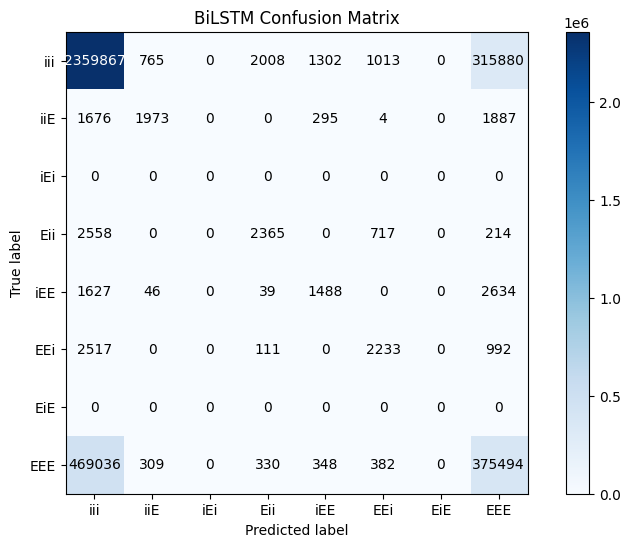

In [10]:
from scikitplot.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

plot_confusion_matrix(
    y_target,
    y_pred,
    title="BiLSTM Confusion Matrix",
    labels=[i for i in range(8)],
    figsize=(10, 6)
    )
plt.xticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.yticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.show()

In [11]:
from tqdm import tqdm

bigru_y_pred = []
bigru_y_target = []
for i, r in tqdm(bigru_log.iterrows(), total=bigru_log.shape[0], desc="Reading"):
    target = r["target"].split(" ")
    target = [int(a) for a in target]
    # target = target[1:] # remove CLS
    # target = [a for a in target if a >= 0]
    prediction = r["prediction"].split(" ")
    prediction = [int(a) for a in prediction]
    # prediction = prediction[1:] # remove CLS
    # prediction = prediction[0:len(target)]

    bigru_y_pred += prediction
    bigru_y_target += target

bigru_metrics = Metrics(bigru_y_pred, bigru_y_target)
bigru_metrics.calculate()

classes = [i for i in range(8)]
print(f"Token   Precision   Recall  F1 Score")
for i in classes:
    print(f"{Index_Dictionary[i]}   {bigru_metrics.precision(i)}  {bigru_metrics.recall(i)} {bigru_metrics.f1_score(i)}")



Reading: 100%|██████████| 6961/6961 [00:02<00:00, 2871.41it/s]


Token   Precision   Recall  F1 Score
iii   0.876  0.813 0.843
iiE   0.593  0.456 0.516
iEi   0  0 0
Eii   0.597  0.555 0.575
iEE   0.598  0.452 0.515
EEi   0.617  0.536 0.574
EiE   0  0 0
EEE   0.52  0.641 0.574


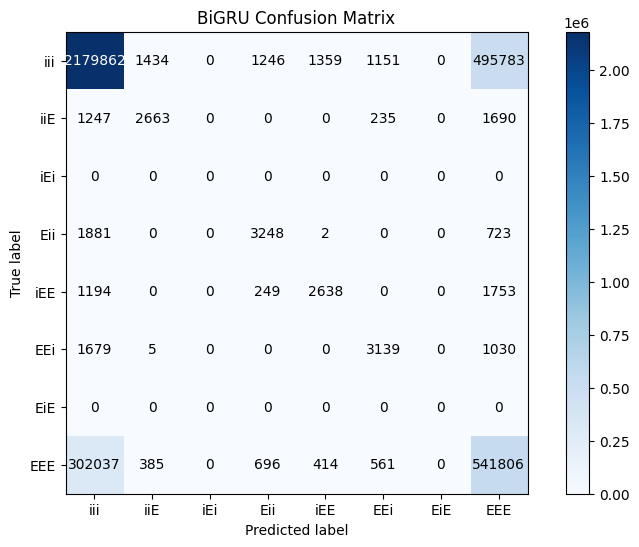

In [15]:
from scikitplot.metrics import plot_confusion_matrix
import seaborn as sn

plot_confusion_matrix(
    bigru_y_target,
    bigru_y_pred,
    title="BiGRU Confusion Matrix",
    labels=[i for i in range(8)],
    figsize=(10, 6)
)
plt.xticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.yticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 2

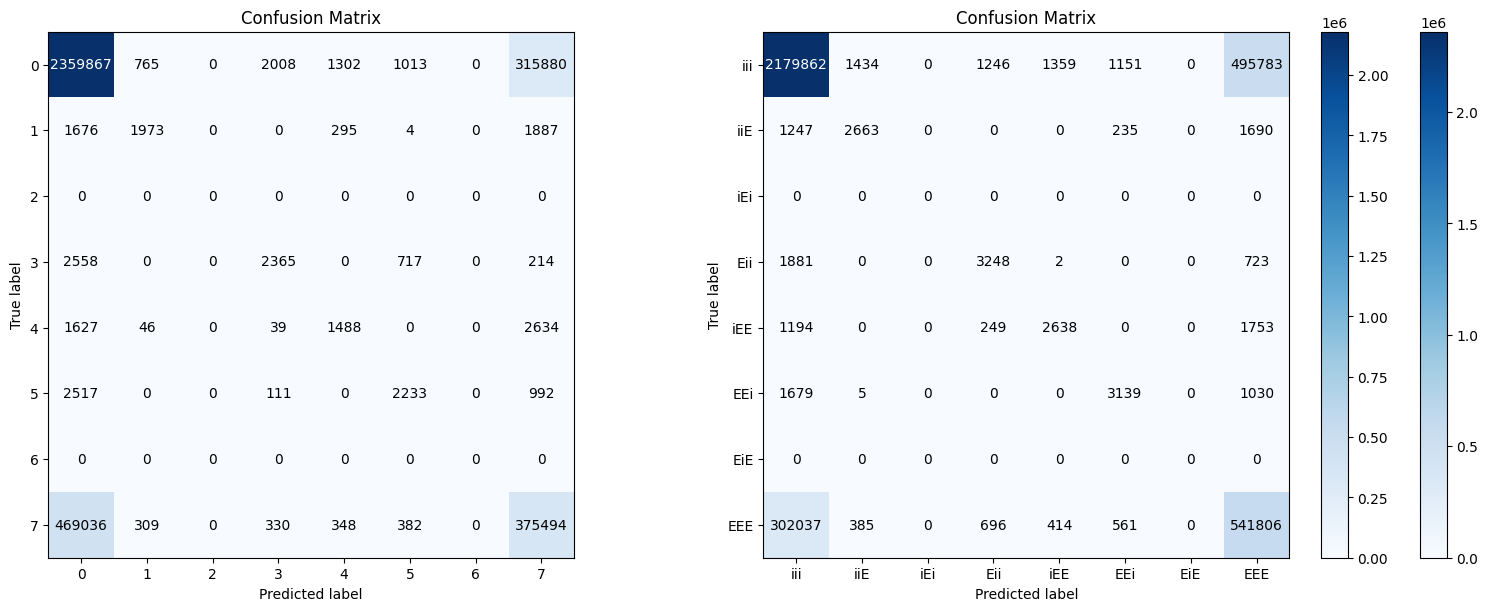

In [35]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

figs, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 6))
a = plot_confusion_matrix(
    y_target,
    y_pred,
    labels=[i for i in range(8)],
    ax=axes[0],
    figsize=(10, 6)
    )

b = plot_confusion_matrix(
    bigru_y_target,
    bigru_y_pred,
    labels=[i for i in range(8)],
    ax=axes[1],
    figsize=(10, 6),
)

plt.xticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.yticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.show()

In [ ]:

plot_confusion_matrix(
    bigru_y_target,
    bigru_y_pred,
    labels=[i for i in range(8)],
    ax=axes[1]
)
plt.xticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.yticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

error_analysis_df = pd.read_csv(
    os.path.join("prediction", "error_analysis_log_sorted.csv")
)

pred_y_pred = []
pred_y_target = []
for i, r in error_analysis_df.iterrows():
    prediction = r["prediction"]
    prediction = [int(a) for a in prediction.split(" ")]
    pred_y_pred += prediction
    target = r["target"]
    target = [int(a) for a in target.split(" ")]
    pred_y_target += target

print(len(pred_y_pred))
print(len(pred_y_target))


3550110
3550110


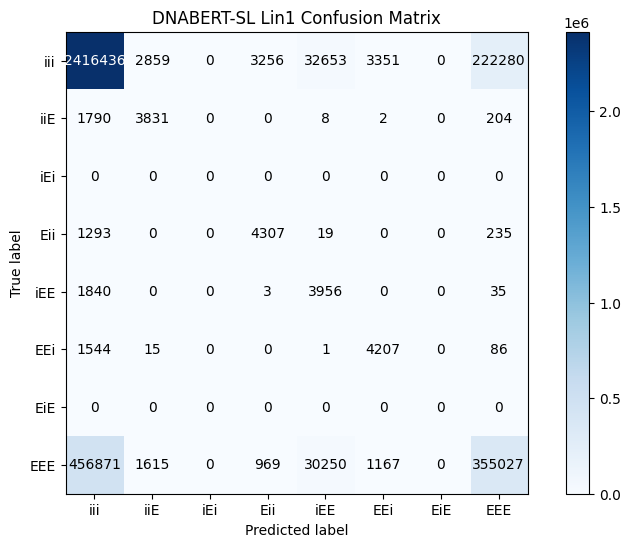

In [7]:
from utils.seqlab import Index_Dictionary
from scikitplot.metrics import plot_confusion_matrix
import seaborn as sn

plot_confusion_matrix(
    pred_y_target,
    pred_y_pred,
    title="DNABERT-SL Lin1 Confusion Matrix",
    labels=[i for i in range(8)],
    figsize=(10, 6)
)
plt.xticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.yticks(ticks=[i for i in range(8)], labels=[Index_Dictionary[i] for i in range(8)])
plt.show()

Path run\baseline\kmer\model\model_bilstm.h5 found
Path run\baseline\kmer\model\model_bigru.h5 found
Path workspace\seqlab-latest\gene_index.01_test_ss_all_pos.csv found


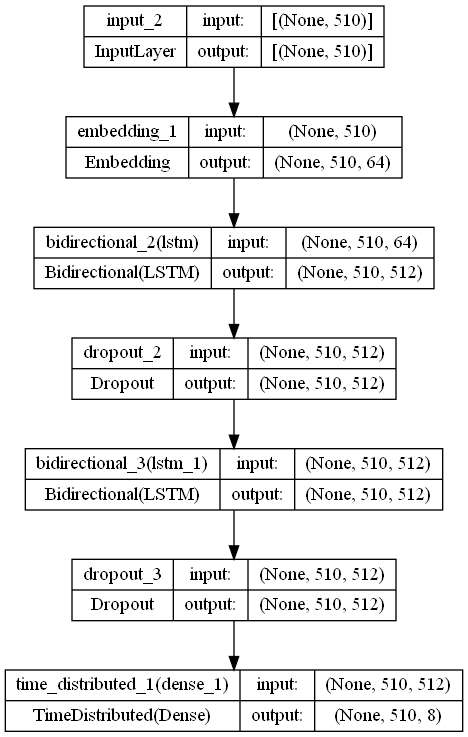

In [2]:
import tensorflow as tf
import os

model_dir = os.path.join("run", "baseline", "kmer", "model")
model_bilstm_path = os.path.join(model_dir, "model_bilstm.h5")
model_bigru_path = os.path.join(model_dir, "model_bigru.h5")
data_dir = os.path.join("workspace", "seqlab-latest")
test_data_path = os.path.join(data_dir, "gene_index.01_test_ss_all_pos.csv")

for p in [model_bilstm_path, model_bigru_path, test_data_path]:
    print(f"Path {p} {'found' if os.path.exists(p) else 'not found'}")


bilstm_model = tf.keras.models.load_model(model_bilstm_path)
bigru_model = tf.keras.models.load_model(model_bigru_path)

tf.keras.utils.plot_model(
    bilstm_model,
    to_file='bilstm_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)


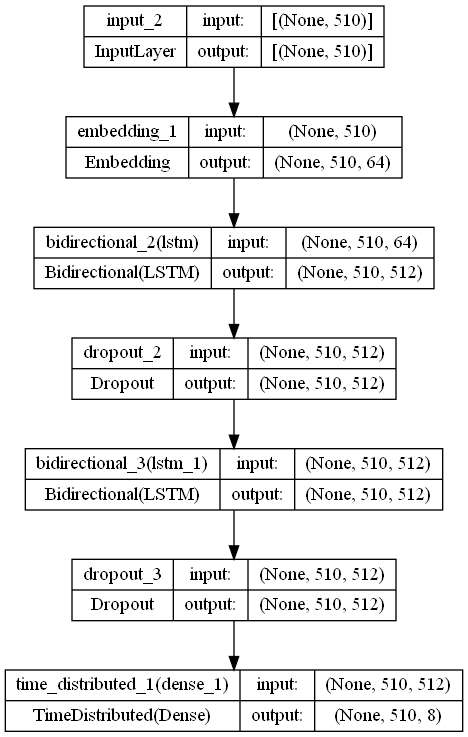

In [3]:
tf.keras.utils.plot_model(
    bilstm_model,
    to_file='bigru_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

Path run\baseline\basic\model-latest\model_bilstm.h5 found
Path run\baseline\basic\model-latest\model_bigru.h5 found
Path workspace\seqlab-latest\gene_index.01_test_ss_all_pos.csv found


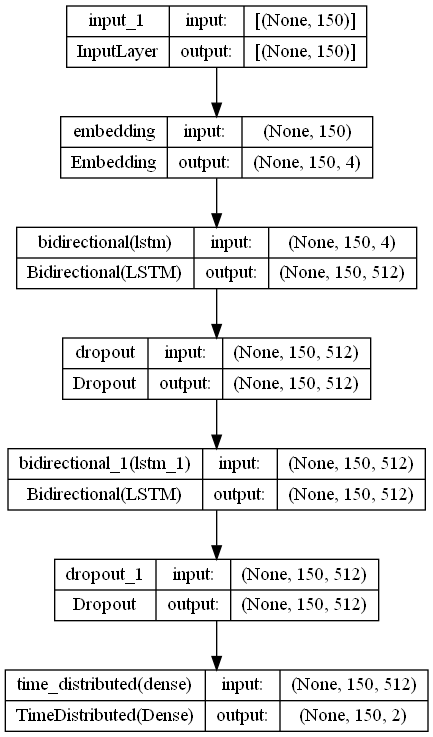

In [14]:
model_dir = os.path.join("run", "baseline", "basic", "model-latest")
model_bilstm_path = os.path.join(model_dir, "model_bilstm.h5")
model_bigru_path = os.path.join(model_dir, "model_bigru.h5")
data_dir = os.path.join("workspace", "seqlab-latest")
test_data_path = os.path.join(data_dir, "gene_index.01_test_ss_all_pos.csv")

for p in [model_bilstm_path, model_bigru_path, test_data_path]:
    print(f"Path {p} {'found' if os.path.exists(p) else 'not found'}")


bilstm_model = tf.keras.models.load_model(model_bilstm_path)
bigru_model = tf.keras.models.load_model(model_bigru_path)

tf.keras.utils.plot_model(
    bilstm_model,
    to_file='bilstm_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

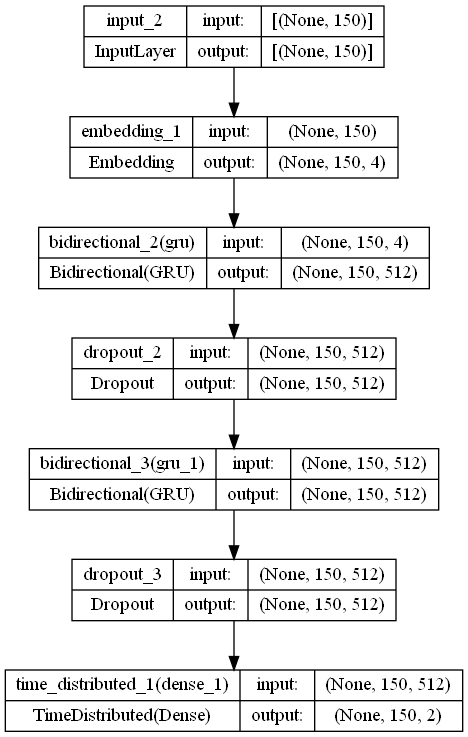

In [15]:
tf.keras.utils.plot_model(
    bigru_model,
    to_file='bigru_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

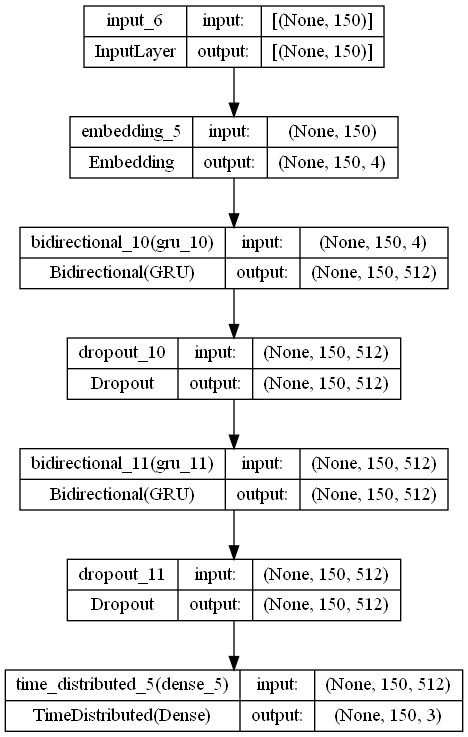

In [11]:
from tf_model.wisesty import bigru
num_classes = 3
bigru_model = bigru(num_classes=3)
tf.keras.utils.plot_model(
    bigru_model,
    to_file='basic_bigru_not_trained.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)